In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [ ]:
import tensorflow as tf
import numpy as np

class ActorCritic(tf.Module):
    def __init__(self, num_inputs, num_actions, num_hidden):
        super().__init__()
        self.common = tf.Variable(tf.random.normal([num_inputs, num_hidden]))
        self.common_bias = tf.Variable(tf.zeros([num_hidden]))
        
        self.action = tf.Variable(tf.random.normal([num_hidden, num_actions]))
        self.action_bias = tf.Variable(tf.zeros([num_actions]))
        
        self.critic = tf.Variable(tf.random.normal([num_hidden, 1]))
        self.critic_bias = tf.Variable(tf.zeros([1]))

    def __call__(self, inputs):
        common = tf.nn.relu(tf.matmul(inputs, self.common) + self.common_bias)
        action = tf.nn.softmax(tf.matmul(common, self.action) + self.action_bias)
        critic = tf.matmul(common, self.critic) + self.critic_bias
        return action, critic

num_inputs = 4
num_actions = 2
num_hidden = 128

model = ActorCritic(num_inputs, num_actions, num_hidden)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
huber_loss = tf.keras.losses.Huber()

In [ ]:
def calculate_losses(history):
    actor_losses = []
    critic_losses = []
    for log_prob, value, ret in history:
        diff = ret - value
        actor_losses.append(-log_prob * diff)
        critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))

    return sum(actor_losses) + sum(critic_losses)


def run_episode(env, model, optimizer, max_steps_per_episode):
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        returns = calculate_returns(rewards_history)
        history = zip(action_probs_history, critic_value_history, returns)
        loss_value = calculate_losses(history)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    return episode_reward


def calculate_returns(rewards_history):
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
    return returns.tolist()




In [ ]:
r_van = []
avg_rvan = []
gamma = 0.99
eps = 0.99
env = gym.make("CartPole-v1")
max_steps_per_episode=100
running_reward = 0
critic_value_history=[]
action_probs_history=[]
rewards_history=[]
for episode_count in range(1, 501):
    episode_reward = run_episode(env, model, optimizer, max_steps_per_episode)
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
    r_van.append(running_reward)
    avg_rvan.append(sum(r_van) / len(r_van))

    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

running reward: 11.83 at episode 10
running reward: 22.70 at episode 20
running reward: 36.55 at episode 30
running reward: 47.07 at episode 40
running reward: 49.47 at episode 50
running reward: 44.60 at episode 60
running reward: 47.72 at episode 70
running reward: 54.06 at episode 80
running reward: 96.53 at episode 90
running reward: 175.98 at episode 100
running reward: 124.49 at episode 110
running reward: 89.57 at episode 120
running reward: 100.80 at episode 130
running reward: 190.73 at episode 140
running reward: 170.81 at episode 150
running reward: 165.81 at episode 160
running reward: 161.63 at episode 170
running reward: 156.48 at episode 180
running reward: 148.05 at episode 190
running reward: 151.93 at episode 200
running reward: 154.87 at episode 210
running reward: 165.03 at episode 220
running reward: 288.44 at episode 230
running reward: 338.91 at episode 240
running reward: 213.77 at episode 250
running reward: 135.18 at episode 260
running reward: 87.25 at episod

In [ ]:
def select_greedy_action(state, model):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    greedy_action = np.argmax(action_probs)
    return greedy_action


def test_model(env, model, num_test_episodes, max_steps_per_episode):
    episode_rewards = []

    for episode in range(num_test_episodes):
        state = env.reset()
        episode_reward = 0

        for timestep in range(1, max_steps_per_episode):
            greedy_action = select_greedy_action(state, model)
            state, reward, done, _ = env.step(greedy_action)
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)

    return episode_rewards


num_test_episodes = 100
episode_rewards = test_model(env, model, num_test_episodes, max_steps_per_episode)
average_reward = np.mean(episode_rewards)
print("Average reward over 100 episodes: {:.2f}".format(average_reward))


Average reward over 100 episodes: 477.28


In [ ]:
# function to plot reward
import matplotlib.pyplot as plt

def plot_reward(reward_list, reward_avg_list):
  plt.plot(reward_list, 'g', label='Reward')
  plt.plot(reward_avg_list, 'r', label='Average Reward')
  plt.xlabel('Episode')
  plt.ylabel('Reward Value')
  plt.title('Rewards Per Episode')
  plt.grid()
  plt.legend()
  plt.show()
def plot_rewards(reward_list):
  plt.plot(reward_list, 'g', label='Reward')
  plt.xlabel('Episode')
  plt.ylabel('Reward Value')
  plt.title('Rewards Per Episode')
  plt.grid()
  plt.legend()
  plt.show()

# function to plot epsilon
def plot_epsilon(epsilon_list):
  plt.plot(epsilon_list)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon Values')
  plt.title('Epsilon Decay')
  plt.grid()
  plt.show()

# save rewards
def save(file_name, save_list):
  with open(file_name, 'wb') as file:
    pickle.dump(save_list, file)

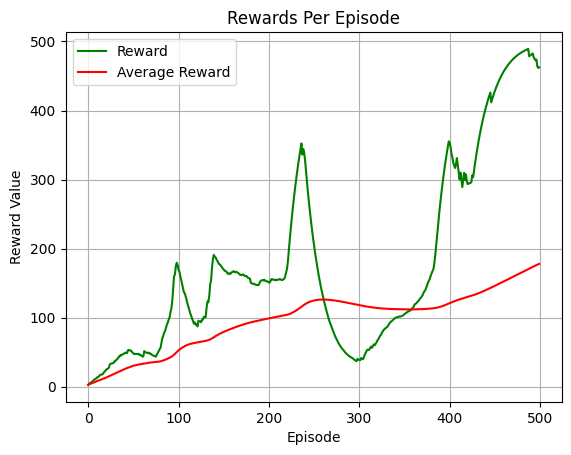

In [ ]:
plot_reward(r_van,avg_rvan)

#Training


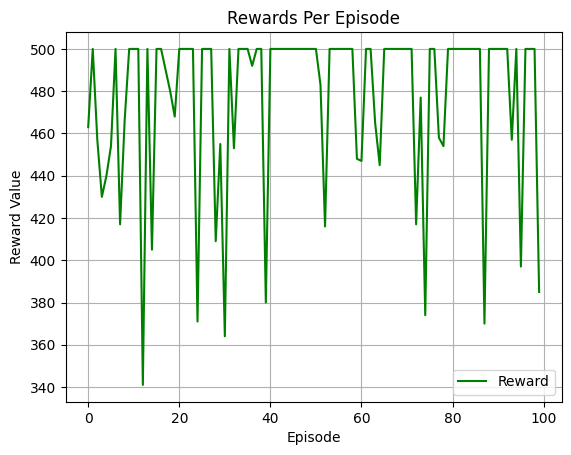

In [ ]:
plot_rewards(episode_rewards)
#Evaluation

In [ ]:
import pickle

with open("a2c_vanilla_cartpole_train.pkl", "wb") as f:
    pickle.dump(r_van, f)

with open("a2c_vanilla_cartpole_test.pkl", "wb") as f:
    pickle.dump(episode_rewards, f)